In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import numpy.linalg as la

In [2]:
# Drone properties
l = .2 # m (length of an arm)
R = .075 # m (radius of rotor)
m = 2 # kg (mass of drone)
g = 9.81 # m/s^2
kt = .1 # thrust coefficient for rotors, TBD
km = .001 # moment coefficient for rotors, TBD
I = np.diag([.02, .02, .04]) # intertia matrix, update w actual values, TBD

# Define initial conditions for the drone! Does it start with inputs?

# Position (meters)
r_x, r_y, r_z = 0, 0, 0
r = np.array([r_x, r_y, r_z])

# Yaw, pitch, roll angles (radians)
phi, theta, psi = 0, 0, 0
eulers = np.array([phi, theta, psi])

# Linear velocity (m/s)
v_x, v_y, v_z = 0, 0, 0
v = np.array([v_x, v_y, v_z])

# Angular velocity (rad/s)
w_x, w_y, w_z = 0, 0, 0
w = np.array([w_x, w_y, w_z])

# Rotor torques
tau_x, tau_y, tau_z = 0, 0, 0
tau = np.array([tau_x, tau_y, tau_z])

# Rotor rotations
w1, w2, w3, w4 = 0, 0, 0, 0
rotors = np.array([w1, w2, w3, w4])

# Translational force
a = np.array([0, 0, -g])
f = m*a

# rotation matrices
def R_zyx(phi, theta, psi):
    cφ, sφ = np.cos(phi), np.sin(phi)
    cθ, sθ = np.cos(theta), np.sin(theta)
    cψ, sψ = np.cos(psi), np.sin(psi)

    yaw = np.array([[cψ, -sψ, 0],
                   [sψ,  cψ, 0],
                   [0,      0, 1]])
    pitch = np.array([[cθ, 0, sθ],
                   [0, 1, 0],
                   [-sθ, 0, cθ]])
    roll = np.array([[1, 0, 0],
                   [0, cφ, -sφ],
                   [0, sφ,  cφ]])

    return yaw @ pitch @ roll

def euler_rates(phi, theta, w_x, w_y, w_z):
    return np.array([
        w_x + w_y*np.sin(phi)*np.tan(theta) + w_z*np.cos(phi)*np.tan(theta),
        w_y*np.cos(phi) - w_z*np.sin(phi),
        w_y*np.sin(phi)/np.cos(theta) + w_z*np.cos(phi)/np.cos(theta)
    ])

In [3]:
# General function for defining the overall force and moments produced by each rotor.
def fam(rotors):
    w1, w2, w3, w4 = rotors
    T1 = kt * w1**2
    T2 = kt * w2**2
    T3 = kt * w3**2
    T4 = kt * w4**2
    Tx = (T1 + T2 + T3 + T4) * np.sin(theta)
    Ty = (T1 + T2 + T3 + T4) * np.sin(phi)
    Tz = (T1 + T2 + T3 + T4) * np.cos(theta) * np.cos(phi)

    tau_phi   = l * (T2 - T4) #rewrite
    tau_theta = l * (T3 - T1) #rewrite
    tau_psi   = km * (w1**2 - w2**2 + w3**2 - w4**2) #rewrite
    
    return np.array([Tx, Ty, Tz]), np.array([tau_phi, tau_theta, tau_psi])

def step(rin, vin, eulersin, win, rotorsin, dt):
    T, tau = fam(rotorsin)

    # Translational

    R = R_zyx(eulersin[0], eulersin[1], eulersin[2])
    fout = R @ T - np.array([0,0,m*g]) 
    aout = fout/m 
    vout = vin + aout*dt 
    rout = rin + vout*dt 

    # Rotational

    domega = la.inv(I) @ (tau - np.cross(win, I@w))

    # Euler angle rates
    dphi, dtheta, dpsi = euler_rates(phi, theta, w[0], w[1], w[2])
    wout = win + np.array([domega[0]*dt, domega[1]*dt, domega[2]*dt])
    eulersout = eulersin + np.array([dphi*dt, dtheta*dt, dpsi*dt])

    return rout, vout, aout, fout, eulersout, wout

def circularpath(radius, vtarget, t_tot, ro, vo, ao, fo, eulerso, wo):
    r = ro
    v = vo
    a = ao
    f = fo
    eulers = eulerso
    w = wo
    t = 0
    dt = .5 #how often it updates

    # Need a particular centripetal acceleration to move in a 2m rad circle @ .5m/s
    a_ctarget = vtarget**2 / radius
    thetatarget = np.arctan(a_ctarget / g) # tilt to get this ac
    T1 = (m*g * .25) - .5*m*g*np.tan(thetatarget)
    T2 = (m*g * .25)
    T3 = (m*g * .25) + .5*m*g*np.tan(thetatarget)
    T4 = (m*g * .25)
    rotors = np.array([np.sqrt(T1 / kt), -np.sqrt(T2 / kt), np.sqrt(T3 / kt), np.sqrt(T4 / kt)])

    #yawratetarget = vtarget / radius
    #tau_psitarget = I[2][2] * yawratetarget
    #dpsi = tau_psitarget / (2 * km) 
    #rotors = rotors + np.array([np.sqrt(dpsi), -np.sqrt(dpsi), np.sqrt(dpsi), -np.sqrt(dpsi)])

    # Now move in circle
    while (t < t_tot):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        print(eulers, r, "R = ", np.sqrt(r[0]**2 + r[1]**2), v, "t = ", t)
        t = t + dt

# circularpath(2, .5, 5, r, v, a, f, eulers, w)


In [4]:
# Task 1. Hover at 1m for 2 mins.
def hoverforatime(t_tot, ro, vo, ao, fo, eulerso, wo):
    t = 0
    dt = 1
    r = ro
    v = vo
    a = ao
    f = fo
    eulers = eulerso
    w = wo

    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    rotorovertime = []

    thrust_perrotor = (m * 9.81) / 4
    rotors = np.sqrt(thrust_perrotor / kt), -np.sqrt(thrust_perrotor / kt), np.sqrt(thrust_perrotor / kt), -np.sqrt(thrust_perrotor / kt) # T = k w^2
    power = 4 * np.sqrt(thrust_perrotor**3 / (2*1.225*np.pi*(R**2))) #as given in sources

    while (t <= t_tot):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        # print("az = ", a[2], "vz = ", v[2], "rz = ", r[2], "t = ", t)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        t += dt
    return tovertime, rovertime, vovertime, eulersovertime

t_t, r_t, v_t, eulers_t = hoverforatime(120, r, v, a, f, eulers, w)

Text(0, 0.5, 'Roll Angle (degrees)')

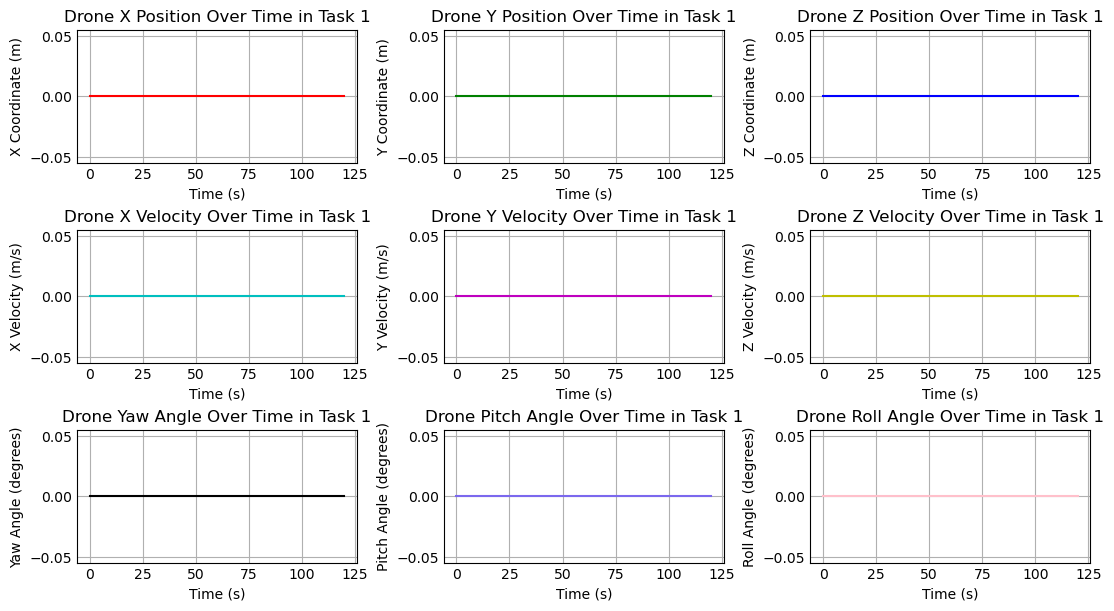

In [5]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 1', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 1')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 1')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 1', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 1')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 1')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Yaw Angle Over Time in Task 1', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Yaw Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 1')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Roll Angle Over Time in Task 1')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Roll Angle (degrees)')

In [6]:
# Task 3. Launch from ground and ascend vertically until 1m above ground. Move in a straight line 1m above ground at an average speed of 1m/s for 5m,
# stop (hover), yaw 90 deg to the left, move in another straight line for 5m, stop (hover), land vertically with a speed of no more than 1cm/s.
def riseaheight(h_tot, ro, vo, ao, fo, eulerso, wo):
    h = ro[2]
    r = ro
    v = vo
    a = ao
    f = fo
    eulers = eulerso
    w = wo
    dt = 1 #how often it updates
    t = 0

    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    rotorovertime = []

    thrust_perrotor = .011 + ((m * 9.81) / 4)
    rotors = np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt) # T = k w^2
    power = 4 * np.sqrt(thrust_perrotor**3 / (2*1.225*np.pi*(R**2)))

    while (h < h_tot):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        h = r[2]
        t += 1
    return tovertime, rovertime, vovertime, eulersovertime, powerovertime, rotorovertime

t_t, r_t, v_t, eulers_t, _, _ = riseaheight(2, r, v, a, f, eulers, w) #change rotors to stop rising

Text(0, 0.5, 'Roll Angle (degrees)')

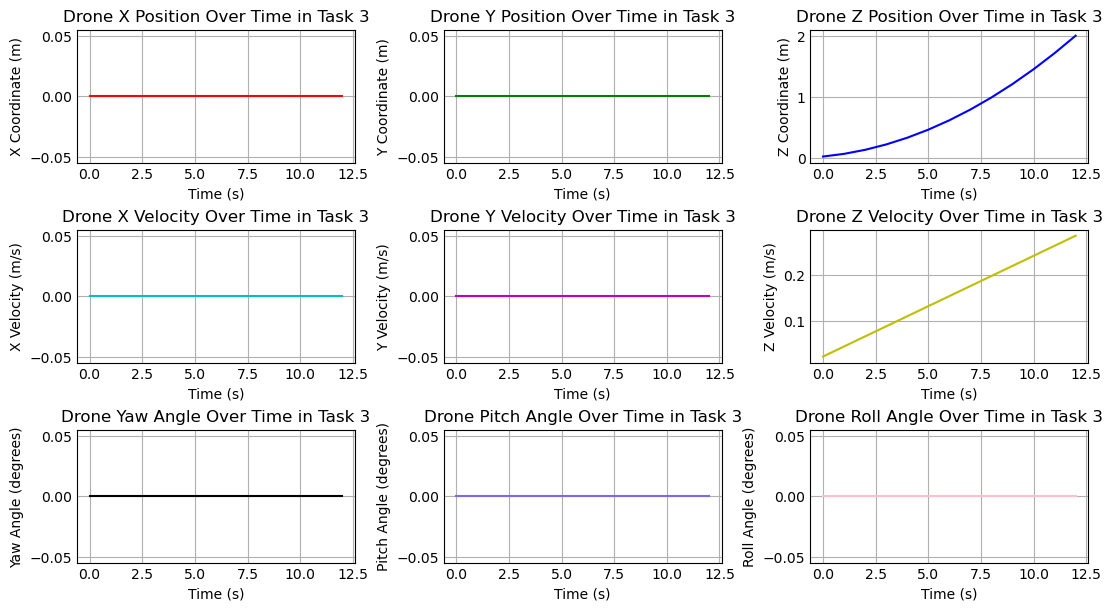

In [7]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 3', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 3')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 3')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 3', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 3')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 3')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Yaw Angle Over Time in Task 3', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Yaw Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 3')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Roll Angle Over Time in Task 3')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Roll Angle (degrees)')

In [102]:
#old
def task_1 (t_tot, r, eulers, v, a, f, w_rotors):
    t = 0
    dt = 1
    
    
    # Update EOM... is this sufficient

    thrust = (m * 9.81) / 4 # Hard code
    w_rotors = np.sqrt(thrust), -np.sqrt(thrust), np.sqrt(thrust), -np.sqrt(thrust) # T = k w^2
    f = f + np.array([0, 0, 4*thrust])

    # While loop to accomplish task 1. in this case we are flying for time, could change to loop with position. equations would update. this is basic case

    while (t < t_tot):
        t += dt
        a = f/m
        v = v + a*dt
        r = r + v*dt

        print(a[2], v[2], r[2]) #print for now, can create an array (keep track parallel to a time array) so that we can easily generate graphs later on

    P_task_1 = 4 * np.sqrt(thrust**3 / (2*1.225*np.pi*(R**2))) #as given in sources
    return P_task_1
#task_1(5, r, eulers, v, a, f, rotors)
        

In [103]:
#old
def rise (h_tot, r, eulers, v, a, f, w_rotors):
    h = 0
    #dh = 10
    t = 0
    dt = .1
    # Update EOM... is this sufficient

    thrust = (1.1 * m * 9.81) / 4 # Hard code
    w_rotors = np.sqrt(thrust), -np.sqrt(thrust), np.sqrt(thrust), -np.sqrt(thrust) # T = k w^2
    f = f + np.array([0, 0, 4*thrust])

    # While loop to accomplish task 1. in this case we are flying for time, could change to loop with position. equations would update. this is basic case

    while (h < h_tot):
        t += dt
        a = f/m
        v = v + a*dt
        rz = r[2]
        r = r + v*dt
        h += r[2] - rz
        print(a[2], v[2], r[2]) #print for now, can create an array (keep track parallel to a time array) so that we can easily generate graphs later on
    P_task_1 = 4 * np.sqrt(thrust**3 / (2*1.225*np.pi*(R**2))) #as given in sources
    # update rotors to be at hover speed
    return P_task_1
#rise (.1, r, eulers, v, a, f, rotors)